# Kaggling into an Iceberg
> Using random forest techniques to predict survival on the Titanic

- toc: true
- badges: true
- comments: true
- author: Matt Bowen
- categories: [jupyter]
- comments: true

## Introduction

The next lesson in the [fastai course](https://course.fast.ai/) covered tabular data. According to the course, the vast majority of datasets on tabular data are best modeled by ensembles of decision trees, such as random forests, so the lesson focused on them. 

They used a particular Kaggle competition, the [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers) as their hands-on example for walking through how to understand, build, train, and infer using decision trees and random forests.

While I had heard of Kaggle previously, I had never used it myself before. Fortunately, Kaggle itself points you to the [Titanic](https://www.kaggle.com/c/titanic) competition as a starting point. The premise is that you're given a dataset of passengers on the Titanic and whether or not they survived to train on and you have to predict which passengers in another dataset of passengers survived. 

As my introduction to both Kaggle and random forests, I thought I would try to walk through the course's random forest discussion using the Titanic competition data and see what happens.

(In the collapse below is all the imports and pandas settings I'll end up using at the top just to keep them all together.)

In [2]:
#collapse
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss

# Pandas display options
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## Setup and Random Guess

The competition provides three files: 
 - training set (passenger data with 'Survived' column)
 - test set (passenger data with no 'Survived' column)
 - sample submission assuming all and only female passengers survived
 
Since I'll use it often, I'll set up the dependent variable ('Survived') here as well.

In [27]:
dep_var = 'Survived'
train_df = pd.read_csv("titanic_train.csv", low_memory=False)
test_df = pd.read_csv("titanic_test.csv", low_memory=False)

Here's what the training data looks like:

In [3]:
train_df

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",...,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",...,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",...,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",...,111369,30.0000,C148,C


The competition page has a description of each of the columns, so I won't rehash those here.

As a first pass to give something to compare against, I built a randomly chosen set where the survival was determined at random based on the survival rate of the training data. The score for this random set ended up being 52.39%.

In [4]:
##
# Submit random set
total_died, total_survived = train_df.value_counts(dep_var)
ratio = total_died / (total_survived + total_died)
test_length = len(test_df)
random_survived = np.random.choice(2, test_length, p=[ratio, 1 - ratio])
random_data_frame = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : random_survived})
random_data_frame.to_csv("titanic_random.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_random.csv -m "Random based on survival rate"`

In [5]:
# hide_input
print(f"Score: {0.52392}")

Score: 0.52392


## Decision Trees

Now, it's time to do something other than just guess. I started by splitting the categorical and continuous columns using a `fastai` designed specifically for that. Then, I split the provided training data into training and validation sets using `TabularPandas`.

In [60]:
##
# Split the columns into categorical and continuous
cont_cols, cat_cols = cont_cat_split(train_df, 1, dep_var=dep_var)
print(f"Continuous columns: {cont_cols}")
print(f"Categorical columns: {cat_cols}")

Continuous columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [61]:
##
# Operations for columns
column_ops = [Categorify, FillMissing]
# Split the training data randomly
splits = RandomSplitter()(range_of(train_df))
tab_panda = TabularPandas(train_df, column_ops ,cat_cols, cont_cols, y_names=dep_var, splits=splits)
trainxs, trainy = tab_panda.train.xs, tab_panda.train.y
validxs, validy = tab_panda.valid.xs, tab_panda.valid.y
len(trainxs), len(validxs)

(713, 178)

In [62]:
tab_panda.show(3)

,Name,Sex,Ticket,Cabin,Embarked,Age_na,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
420,"Gheorgheff, Mr. Stanio",male,349254,#na#,C,True,421,3,28.0,0,0,7.8958,0
392,"Gustafsson, Mr. Johan Birger",male,3101277,#na#,S,False,393,3,28.0,2,0,7.9250,0
238,"Pengelly, Mr. Frederick William",male,28665,#na#,S,False,239,2,19.0,0,0,10.5000,0


The lesson used a `DecisionTreeRegressor`, but since 'Survived' is a categorical and not continuous variable, I used `DecisionTreeClassifier` instead. For the same reason, `zero_one_loss` makes more sense to be the loss function rather than using the mean square error.

In [ ]:
##
# Simple decision tree classifier
model = DecisionTreeClassifier()
model.fit(trainxs, trainy)
print(f"Error: {zero_one_loss(model.predict(validxs), validy)}")

In [64]:
# hide_input
print(f"Error: 0.2415730337078652")

Error: 0.2415730337078652


Essentially, this is saying the model got ~24% of the validation passenger set wrong when predicting their survival.

In the default, the model can split a node as long as there is at least 1 sample for each leaf. Following the lesson, I checked to see how many leaves for my model were created vs. how many rows in the training data

In [11]:
model.get_n_leaves(), len(trainxs)

(117, 713)

The Titanic dataset is much, much smaller than the Blue Book of Bulldozers dataset, but this number of leaves seemed reasonable to me (6 per leaf or so). However, because it was easy to do so, I decided to iterate the `min_samples_leaf` parameter to try to get a better model:

In [ ]:
##
# min_samples_leaf optimization
best_error, best_min_samples, best_model = (None, None, None)
for min_samples in range(1, 21):
    model = DecisionTreeClassifier(min_samples_leaf=min_samples)
    model.fit(trainxs, trainy)
    error = zero_one_loss(model.predict(validxs), validy)
    if best_error is None or best_error > error:
        best_error, best_min_samples, best_model = (error,  min_samples, model)
print(f"Best model error: {best_error}")
print(f"Min samples per leaf: {best_min_samples}, Number leaves: {best_model.get_n_leaves()}")

In [13]:
#hide_input
print(f"Best model error: {0.1966292134831461}")
print(f"Min samples per leaf: {3}, Number leaves: {70}")

Best model error: 0.1966292134831461
Min samples per leaf: 3, Number leaves: 70


The default minimum samples per leaf is 1 for DecisionTreeClassifier, but it seems the optimization helped. A minimum of 3 samples per leaf yields a better result on the validation, so I'll use that model to submit to kaggle.

### Data Cleanup

Before I could predict using that model, there is an issue with the test data that had to be addressed. The 'Fare' column had a null value for one of the test passengers, while neither the test or valid set had any null values in that column. 

A standard way to fill in that value is to use the mean of the training set, so that's what I did. Pandas makes this substitution pretty easy, once you figure out the proper syntax.

In [28]:
##
# Find the null row(s) in the 'Fare' column
nan_row = test_df[test_df['Fare'].isnull()]
# Set the fare in that row to the mean of the training data
test_df.at[nan_row.index, 'Fare'] = train_df['Fare'].mean()
# Display the newly fixed row
display(test_df.loc[nan_row.index])

,PassengerId,Pclass,Name,Sex,...,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,...,3701,32.204208,NaN,S


With the row fixed, I converted the test data to a `TabularPandas`. We'll use this again and again to feed into our models for survival prediction.

In [15]:
##
# Convert test data to TabularPandas
test_tab = TabularPandas(test_df, [Categorify, FillMissing], cat_cols, cont_cols)

### Decision Tree Results

With the test data cleaned up, I used the best decision tree model that I found to predict the survivors on the test set and submit the results to kaggle:

In [16]:
##
# Decision Tree Classifier set (Score: 0.70813)
# Predict the survivors
dt_survived = best_model.predict(test_tab.xs)

test_length = len(test_df)
dt_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : dt_survived})
dt_df.to_csv("titanic_dt.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_dt.csv -m "Single decision tree"`

In [17]:
# hide_input
print(f"Score: {0.70813}")

Score: 0.70813


## Random Forest

If one decision tree is good, how about more? Next, I'll walk through the random forests of decision trees that create to tackle this competition.

Following the course approach, I made a function to make creating a random forest and fit it in single step. Similar to above, since I'm looking for a yes or no answer, instead of a continuous one, I'll use `RandomForestClassifier` instead of a regression model.

In [18]:
##
# create random forest and fit it
def create_rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_features=max_features, 
                                  min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

With that function, I can create a random forest, fit it to the training data, and score it against the validation data:

In [ ]:
##
# First pass model with error
# Model error: 0.1797752808988764
# Model oob error: 0.18513323983169705
model = create_rf(trainxs, trainy)
error = zero_one_loss(model.predict(validxs), validy)
print(f"Model error: {error}")
print(f"Model oob error: {1.0 - model.oob_score_}")

In [20]:
#hide_input
print(f"Model error: {0.1797752808988764}")
print(f"Model oob error: {0.18513323983169705}")

Model error: 0.1797752808988764
Model oob error: 0.18513323983169705


If 40 trees (`n_estimators`) is good, how about [more](https://imgflip.com/i/4u7pgw)? 

Let's look at models with more trees (`n_estimators`) and see how they do.

In [ ]:
##
# Number of trees (n_estimators) optimization
best_error, best_trees, best_model = (None, None, None)
for num_trees in range(40, 300, 20):
    model = create_rf(trainxs, trainy, n_estimators=num_trees)
    error = zero_one_loss(model.predict(validxs), validy)
    if best_error is None or best_error > error:
        best_error, best_trees, best_model = (error, num_trees, model)
    print(f"Num trees: {num_trees}, error: {error}, oob: {1.0 - model.oob_score_}")
print(f"Best model error: {best_error}, num trees: {best_trees}")

In [22]:
#hide_input
print('''Num trees: 40, error: 0.1797752808988764, oob: 0.18513323983169705
Num trees: 60, error: 0.1685393258426966, oob: 0.18793828892005615
Num trees: 80, error: 0.1741573033707865, oob: 0.1893408134642356
Num trees: 100, error: 0.1797752808988764, oob: 0.1837307152875175
Num trees: 120, error: 0.1629213483146067, oob: 0.18793828892005615
Num trees: 140, error: 0.1685393258426966, oob: 0.1837307152875175
Num trees: 160, error: 0.1685393258426966, oob: 0.1865357643758766
Num trees: 180, error: 0.1685393258426966, oob: 0.1865357643758766
Num trees: 200, error: 0.1629213483146067, oob: 0.1893408134642356
Num trees: 220, error: 0.1629213483146067, oob: 0.18513323983169705
Num trees: 240, error: 0.1685393258426966, oob: 0.1837307152875175
Num trees: 260, error: 0.1685393258426966, oob: 0.18232819074333806
Num trees: 280, error: 0.1741573033707865, oob: 0.1781206171107994
Best model error: 0.1629213483146067, num trees: 120''')

Num trees: 40, error: 0.1797752808988764, oob: 0.18513323983169705
Num trees: 60, error: 0.1685393258426966, oob: 0.18793828892005615
Num trees: 80, error: 0.1741573033707865, oob: 0.1893408134642356
Num trees: 100, error: 0.1797752808988764, oob: 0.1837307152875175
Num trees: 120, error: 0.1629213483146067, oob: 0.18793828892005615
Num trees: 140, error: 0.1685393258426966, oob: 0.1837307152875175
Num trees: 160, error: 0.1685393258426966, oob: 0.1865357643758766
Num trees: 180, error: 0.1685393258426966, oob: 0.1865357643758766
Num trees: 200, error: 0.1629213483146067, oob: 0.1893408134642356
Num trees: 220, error: 0.1629213483146067, oob: 0.18513323983169705
Num trees: 240, error: 0.1685393258426966, oob: 0.1837307152875175
Num trees: 260, error: 0.1685393258426966, oob: 0.18232819074333806
Num trees: 280, error: 0.1741573033707865, oob: 0.1781206171107994
Best model error: 0.1629213483146067, num trees: 120


The model with 120 (or 200 or 220) trees seems to fare best, but all that much better than the model with 40 trees. I'm no expert, I think it is due to the 
[*out-of-bag error*](https://en.wikipedia.org/wiki/Out-of-bag_error). For all of the models, the `oob error` is more than the validation error. That would seem to indicate that the model can't really improve with more adding more trees, but could just be better by random chance.

That said, since they are easy to create and the submission rules for the Titanic competition are generous, I submitted the predictions from the 40-tree, 120-tree, 140-tree, 160-tree, and 220-tree models just to see how they would do.

In [23]:
##
# A few models with different numbers of trees
for num_trees in [40, 120, 140, 160, 220]:
    model = create_rf(trainxs, trainy, n_estimators=num_trees)
    rf_survived = model.predict(test_tab.xs)
    rf_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : rf_survived})
    rf_df.to_csv(f"titanic_rf_{num_trees}.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_rf_40.csv -m "Random forest classifier with 40 trees"`

In [24]:
# hide_input
print(f"40-tree model score: {0.75598}")

40-tree model score: 0.75598


`!kaggle competitions submit -c titanic -f titanic_rf_120.csv -m "Random forest classifier with 120 trees"`

In [25]:
# hide_input
print(f"120-tree model score: {0.76794}")

120-tree model score: 0.76794


`!kaggle competitions submit -c titanic -f titanic_rf_140.csv -m "Random forest classifier with 140 trees"`

In [26]:
# hide_input
print(f"140-tree model score: {0.76076}")

140-tree model score: 0.76076


`!kaggle competitions submit -c titanic -f titanic_rf_160.csv -m "Random forest classifier with 160 trees"`

In [27]:
# hide_input
print(f"160-tree model score: {0.76555}")

160-tree model score: 0.76555


`!kaggle competitions submit -c titanic -f titanic_rf_220.csv -m "Random forest classifier with 220 trees"`

In [28]:
# hide_input
print(f"220-tree model score: {0.77272}")

220-tree model score: 0.77272


Although the 220-tree model ended up doing the best, increasing the number of trees didn't significantly improve the results. (For reference, the percentage difference between the 40-tree and 220-tree model corresponds to 8 people.) I'm not convinced it's anything other than random chance.

That said, how about [even more](https://memegenerator.net/instance/76641465/billy-mays-but-wait-but-wait-theres-even-more) trees? 3000-tree model inbound:

In [29]:
model3000 = create_rf(trainxs, trainy, n_estimators=3000)
rf_survived = model3000.predict(test_tab.xs)
rf_rf = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : rf_survived})
rf_rf.to_csv(f"titanic_rf_3000.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_rf_300.csv -m "Random forest classifier with 3000 trees"`

In [30]:
# hide_input
print(f"3000-tree model score: {0.76555}")

3000-tree model score: 0.76555


And, it's worse than 220-tree model. I think this supports my earlier assertion that some of the models with more trees are better than the 40 tree model by random chance, rather than anything learned within the models.

### Aside: Simpler models

At this point, before getting into some feature engineering, I went back and read on Kaggle a little bit more about the Titanic competition. As I mentioned above, one of the provided files was a sample submission file where the survivors were assumed to be only and all the female passengers (as determined by the 'Sex' column). How does that submission score?

`!kaggle competitions submit -c titanic -f gender_submssion.csv -m "Only and all female passengers survive"`

In [31]:
# hide_input
print(f"Female only model score: {0.76555}")

Female only model score: 0.76555


This simple model achieved the same score as the 3000-tree model! Let's take a look at the importance of each feature, according to that 3000-tree model. (Again, this is adapted directly from the course.)

<AxesSubplot:ylabel='cols'>

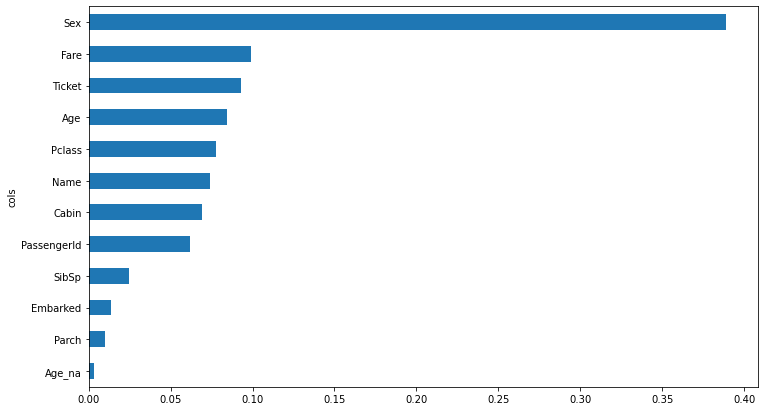

In [32]:
def feature_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=True)
fi = feature_importance(model3000, trainxs)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

From the bar chart, it is abundantly clear that 'Sex' is the most telling feature, with everything else trailing. That said, the 3000-tree model and female-only model actual differ in 62 (of 418) predictions, so they are finding slightly different spaces with the same score.

Because I haven't been able to get [this song](https://youtu.be/2rP1gD9xXkU?t=32) (no, not [that one](https://en.wikipedia.org/wiki/My_Heart_Will_Go_On)) out of my head, I also tried "the women and children fled to the lifeboats put to sea" model. That is, all the women and children survived (but no one else).

In [33]:
##
# Women and children survival model
wac_test_df = pd.DataFrame(test_df)
wac_test_df['Survived'] = np.ones(len(wac_test_df), dtype=int)
wac_cond = (wac_test_df.Sex == 'female') | (wac_test_df.Age < 18)
wac_test_df['Survived'].where(wac_cond, 0, inplace=True)
wac_submit = wac_test_df.loc[:,['PassengerId','Survived']]
wac_submit.to_csv("titanic_wac.csv", index=False)

`#!kaggle competitions submit -c titanic -f titanic_wac.csv -m "Women and children fled to the lifeboats put to sea"`

In [34]:
# hide_input
print(f"Women and children model score: {0.74641}")

Women and children model score: 0.74641


This model scores worse, but not dramatically so.

## Feature Engineering

The next step was to improve the random forest models above by extracting, modifying, or deleting some of the given columns to create new, hopefully more relevant ones by [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). 

I tried lots of different modifications that I came up with on my own, but, in actuality, I couldn't come up with anything that definitely improved on the previous random forests. (The best score I ended up getting was 0.77751.) 

Since I couldn't seem to improve, I ended up reading a number of the discussion posts on Kaggle, particularly those that dealt with random forests and feature engineering. My favorite was [this one](https://www.kaggle.com/zlatankr/titanic-random-forest-82-78), so I decided to adapt it to the syntax I was using. The function I came up with is in the collapse below:

In [36]:
#collapse
def edit_features(df):
    mod_df = df.copy()
    
    # PassengerId - not meaningful for learning
    del mod_df["PassengerId"]
    
    # Pclass - treat passenger class as category
    mod_df["Pclass"] = mod_df["Pclass"].astype("category")
    
    # Name - Split into name length and title
    mod_df['NameLength'] = mod_df["Name"].apply(lambda x: len(x))
    mod_df['NameTitle'] = mod_df["Name"].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
    mod_df['NameTitle'] = mod_df["NameTitle"].astype("category")
    del mod_df["Name"]
    
    # Age - fill Age with mean grouped by title and class
    age_data = mod_df.groupby(['NameTitle', 'Pclass'])['Age']
    mod_df['Age_na'] = mod_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
    mod_df['Age_na'] = mod_df['Age_na'].astype("category")
    mod_df['Age'] = age_data.transform(lambda x: x.fillna(x.mean()))
    
    # SibSp + Parch => Family size category
    passengers = mod_df["SibSp"] + mod_df["Parch"] 
    mod_df['FamilySize'] = np.where(passengers == 0, 'Solo', np.where(passengers <= 3, 'Nuclear', 'Big'))
    mod_df["FamilySize"] = mod_df["FamilySize"].astype("category")
    del mod_df['SibSp']
    del mod_df['Parch']
    
    # Ticket - Split into two categories, 
    #  one based on the first letter of the ticket and 
    #  one based on the length
    mod_df["TicketLetter"] = mod_df["Ticket"].apply(lambda x: str(x)[0])
    mod_df["TicketLetter"] = mod_df["TicketLetter"].apply(lambda x: str(x))
    highTicket = mod_df['TicketLetter'].isin(['1', '2', '3', 'S', 'P', 'C', 'A'])
    lowTicket = mod_df['TicketLetter'].isin(['W', '4', '7', '6', 'L', '5', '8'])
    mod_df['TicketLetter'] = np.where(highTicket, mod_df["TicketLetter"],
                                      np.where(lowTicket, "LowTicket", "OtherTicket"))
    mod_df['TicketLength'] = mod_df['Ticket'].apply(lambda x: len(x))
    del mod_df['Ticket']
    
    # Cabin - Split into the prefix and bin the number
    mod_df["CabinPrefix"] = mod_df['Cabin'].apply(lambda x: str(x)[0])
    mod_df["CabinPrefix"] = mod_df["CabinPrefix"].astype("category")
    del mod_df["Cabin"]
        
    # Embarked - Fill missing data with most common value ('S')
    mod_df['Embarked'] = mod_df['Embarked'].fillna('S')
    
    return mod_df

In [65]:
##
# New data frame with modified features
fe_train_df = edit_features(train_df)
fe_train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'NameLength',
       'NameTitle', 'Age_na', 'FamilySize', 'TicketLetter', 'TicketLength',
       'CabinPrefix'],
      dtype='object')

With the modified features, I ran the training data through the same mechanism as before for creating a random forest

In [38]:
##
# Identify categorical and continuous columns and prep training data
fe_cont, fe_cat = cont_cat_split(fe_train_df, 1, dep_var=dep_var)
fe_splits = RandomSplitter()(range_of(fe_train_df))
fe_tab_panda = TabularPandas(fe_train_df, column_ops, fe_cat, fe_cont, y_names=dep_var, splits=fe_splits)

# Alias training and validation data
fetrainxs, fetrainy = fe_tab_panda.train.xs, fe_tab_panda.train.y
fevalidxs, fevalidy = fe_tab_panda.valid.xs, fe_tab_panda.valid.y

print(f"Categorical columns: {fe_cat}")
print(f"Continuous columns: {fe_cont}")
fe_tab_panda.show(3)

Categorical columns: ['Pclass', 'Sex', 'Embarked', 'NameTitle', 'Age_na', 'FamilySize', 'TicketLetter', 'CabinPrefix']
Continuous columns: ['Age', 'Fare', 'NameLength', 'TicketLength']


,Pclass,Sex,Embarked,NameTitle,Age_na,FamilySize,TicketLetter,CabinPrefix,Age,Fare,NameLength,TicketLength,Survived
769,3,male,S,Mr.,0,Solo,LowTicket,n,32.0,8.362500,32,4,0
49,3,female,S,Mrs.,0,Nuclear,3,n,18.0,17.799999,45,6,0
704,3,male,S,Mr.,0,Nuclear,3,n,26.0,7.854200,23,6,0


In [ ]:
##
# Create a random forest model classifier
fe_model = RandomForestClassifier(n_estimators=300, min_samples_split=5, oob_score=True)

fe_model.fit(fetrainxs, fetrainy)
fe_test_df = edit_features(test_df)
fe_test_tab = TabularPandas(fe_test_df, column_ops, fe_cat, fe_cont)
error = zero_one_loss(fe_model.predict(fevalidxs), fevalidy)

print(f"Model error: {error}")
print(f"Model oob error: {1.0 - fe_model.oob_score_}")

In [40]:
#hide_input
print(f"Model error: {0.1685393258426966}")
print(f"Model oob error: {0.16830294530154277}")

Model error: 0.1685393258426966
Model oob error: 0.16830294530154277


In [41]:
##
# Make and submit predictions
fe_survived = fe_model.predict(fe_test_tab.xs)
fe_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : fe_survived})
fe_df.to_csv("titanic_fe.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_fe.csv -m "Random forest classifier with feature engineering"`

In [42]:
# hide_input
print(f"Random forest with feature engineering model score: {0.78708}")

Random forest with feature engineering model score: 0.78708


This model did score a little bit better than the random forest model{% fn 1 %}. I'm not entirely convinced it's actually better than the non-engineered models though. However, plotting the feature importance, it's pretty easy to see that it is likely the added 'NameTitle' and 'NameLength' features are providing something beyond what 'Name' did. 

<AxesSubplot:ylabel='cols'>

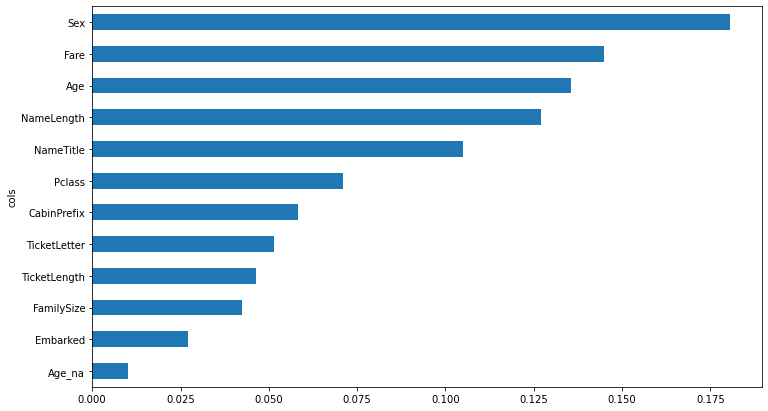

In [66]:
fi = feature_importance(fe_model, fetrainxs)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In any case, even though this feature engineering did not produce a model that blew the other models away, I really liked the justification and the write-up of the author for each change that he made. I think it's good insight on how I might use feature engineering on a less studied dataset.

## Using a Neural Network

Changing gears, let's see if a neural network would garner better results. 

First, I needed to set up the data. I dropped the `PassengerId` column, since it's just an index, and set up the `TabularPandas` similar to before, the only major change is the addition of the `Normalize` operation.

In [67]:
##
# Split the columns by cardinality of 500
nn_cont_cols, nn_cat_cols = cont_cat_split(train_df, dep_var=dep_var)
# Drop the counter variable
nn_cont_cols.remove('PassengerId')
# Added the Normalize operation
nn_procs = [Categorify, FillMissing, Normalize]
# Make the TabularPandas object
nn_train_tab = TabularPandas(train_df, nn_procs, nn_cat_cols, nn_cont_cols, 
                             splits=splits, y_names=dep_var, y_block=CategoryBlock)

Next, I set up the `DataLoader` and the learner itself and made a stab at finding an appropriate learning rate.

In [68]:
nn_dls = nn_train_tab.dataloaders(512)
learn = tabular_learner(nn_dls, loss_func=F.l1_loss)

After experimenting with a number of different epochs, I found that 300 epochs with a learning rate of 0.04 seemed to give reasonable results on the validation set and not take forever (~5 seconds).

In [70]:
lr = 4e-2
epochs = 300
with learn.no_logging(): # Prevents display of the 300 rows of epochs
    learn.fit_one_cycle(epochs, lr)
train_error, valid_error = learn.recorder.values[-1]
print(f"Training error: {train_error}")
print(f"Validation error: {valid_error}")

Training error: 0.014065220020711422
Validation error: 0.1932232528924942


From there, it was fairly easy to make predictions, once I found the right incantation to get the test data in the right format (`learn.dls.test_dl`), call the right prediction function (`get_preds`), and flatten the predictions to a single vector:

In [72]:
##
# Make and submit predictions
_, nn_predictions = learn.get_preds(dl=learn.dls.test_dl(test_df))
nn_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : nn_predictions.flatten()})
nn_df.to_csv("titanic_nn.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_nn.csv -m "Neural network predictions"`

In [48]:
#hide_input
print(f"Neural network score: {0.74641}")

Neural network score: 0.74641


As you can see, the neural network didn't score that much worse that the random forest models.

## Ensemble

Now, I've got a handful of models that take slightly different approaches (or at least use different numbers of trees). I can combine them all into a single model. There may be other ways to approach this, but the simplest thing that came to my mind was to use a majority vote to decide who survived. Below is the ensemble that scored best on the competition test set of the ones that I tried.

In [57]:
##
# Gather the models
model_files = ["titanic_rf_220.csv", # 220-tree Random Forest
               "titanic_rffe.csv", # RF with feature engineering
               "titanic_nn.csv", # Neural network model
               "gender_submission.csv" # Women only survival
              ]

# Combined the models into a table
data = []
for i, mfile in enumerate(model_files):
    model_df = pd.read_csv(mfile)
    data.append(model_df['Survived'])
df = pd.DataFrame(data)

# Majority vote
ensemble_survived = pd.to_numeric(df.mode().iloc[0], downcast='integer')

# Save to csv and submit
ensemble_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : ensemble_survived})
ensemble_df.to_csv("titanic_ensemble.csv", index=False)

`!kaggle competitions submit -c titanic -f titanic_ensemble.csv -m "Ensemble"`

In [59]:
#hide_input
print(f"Ensemble score: {0.78468}")

Ensemble score: 0.78468


In this case, the ensembles didn't score any better than the best individual models. It appears I have reached the limits of what I able to do with the approaches directly mentioned in the `fastai` lesson. I'm going to end my adventure with the Titanic here, since I worked the entire way through the lesson, but I have to say that was fun. 

If I were to continue, I would be taking a much closer look at [this notebook](https://www.kaggle.com/startover205/fastai-2-titanic-rf), which used a very similar `fastai` approach and achieved a score above 98%. They supplemented their data with [this extended set](https://www.kaggle.com/pavlofesenko/titanic-extended), however.

{{ "Interestingly, though, I couldn't get it to quite match the claimed success of the notebook I borrowed it from (82%). I don't think it's my code though, since when I ran their exact code: https://github.com/zlatankr/Projects/tree/master/Titanic, I also got 77-78%." | fndetail: 1}} 